In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import tensorflow as tf
print('Tensorflow version', tf.__version__)
from functools import partial

from include import decoder
from include import fit
from include import helpers 

from matplotlib import pyplot as plt

Tensorflow version 1.12.0


# Load Inputs

In [2]:
def get_noisy_img(img, sig=30, noise_same=False):
    """Returns noisy version of the input image"""
    sigma = sig / 255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img.shape[:-1])
        noise = np.stack([noise] * img.shape[-1], axis=-1)
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img.shape)

    img_noisy = np.clip(img + noise, 0, 1).astype(np.float32)
    return img_noisy

img_clean = helpers.load_img('test_data/', 'astronaut')

# Fit noisy image

In [3]:
def denoise(img_noisy, img_clean, k=128, numit=1900, rn=0.0, 
            find_best=True, upsample_first=False, device='gpu'):
    num_channels = [k] * 5
    img_clean = img_clean[None, :, :, :]
    img_noisy = img_noisy[None, :, :, :]
    net_fn = partial(decoder.decodernw,
                     num_output_channels=img_noisy.shape[-1], 
                     num_channels_up=num_channels,
                     upsample_first=upsample_first
                    )
    _, mse_t, _, out_img = fit.fit(num_channels=num_channels,
                                   reg_noise_std=rn,
                                   num_iter=numit,
                                   img_noisy=img_noisy,
                                   net=net_fn,
                                   img_clean=img_clean,
                                   find_best=find_best,
                                   device=device
                                   )                 
    return out_img[0], mse_t

def plot_results(out_img, img_clean, img_noisy):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 15))
    
    ax1.imshow(img_clean)
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2.imshow(img_noisy)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % helpers.psnr(img_clean, img_noisy))
    ax2.axis('off')

    ax3.imshow(out_img)
    ax3.set_title( "Deep-Decoder denoised image, SNR: %.2f" % helpers.psnr(img_clean, out_img)) 
    ax3.axis('off')    
    plt.show()

shape:  [1, 16, 16, 128]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 01890] loss=0.01193  true loss=0.00131  true loss orig=0.00131  noise energy=0.01239
Best MSE (wrt noisy) 0.011962822
MSE (wrt true) 0.0012470067


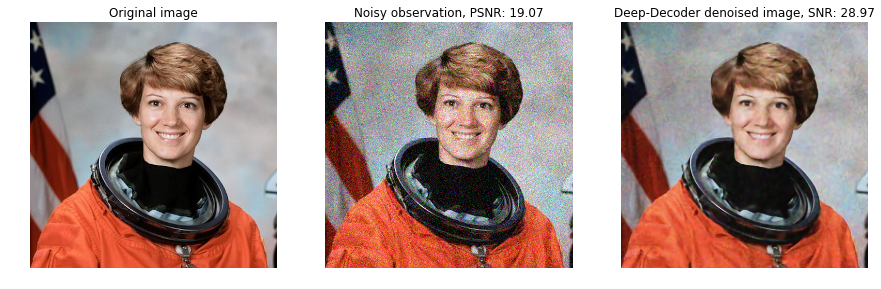

In [4]:
img_noisy = get_noisy_img(img_clean)
out_img, _ = denoise(img_noisy, img_clean)
plot_results(out_img, img_clean, img_noisy)

shape:  [1, 16, 16, 128]
optimize with adam 0.01
Final graph size: 2.56 MB
[Iteration 09990] loss=0.01233  true loss=0.00129  true loss orig=0.00115  noise energy=0.01239
Best MSE (wrt noisy) 0.01229074
MSE (wrt true) 0.001227354


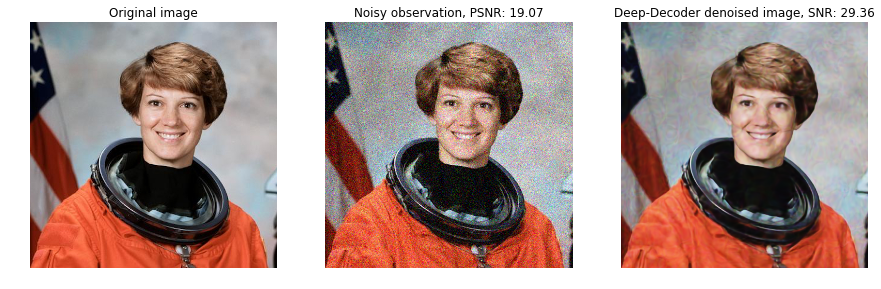

In [8]:
img_noisy = get_noisy_img(img_clean)
out_img, _ = denoise(img_noisy, img_clean, k=128, numit=10000, rn=0.015, upsample_first=True)
plot_results(out_img, img_clean, img_noisy)

#  Choice of number of layers

The number of layers $k$ is a hyperparameter that enables trading off amount of noise that is removed versus the representation error by the model. Smaller $k$ remove more of the noise, but also increase the error of approximating an image with the deep decoder. The optimal choise of $k$ depends on the noise level. To illustrate this consider the experiment below.

The following series of plots show the PSNR of the output of the deep decoder during training as a function of iteration number. The blue curves correspond to k=32, the orange corresponds to k = 64, and the green corresponds to k = 128.

In [27]:
def best_k(ks, sig=70, numit=400, noise_same=False, find_best=True):
    global img_clean
    img_noisy = get_noisy_img(img_clean, sig=sig, noise_same=noise_same)
    print("Noisy observation, PSNR: %.2f" % helpers.psnr(img_clean, img_noisy))
    mses = []
    psnrs = []
    plt.figure(figsize=(11, 6))
    plt.yscale('log')
    plt.xscale('log')
    for k in ks:
        out_img, mse_t = denoise(img_noisy, img_clean, k=k, numit=numit, rn=0.0)
        psnrs += [helpers.psnr(img_clean, out_img)]
        plt.plot(1 + np.arange(len(mse_t)), mse_t, label='k = %d' % k)        
    plt.legend(loc=3)
    plt.show()
    print('\n'.join('k = %d, PSNR = %f' % (k, psnr) for (k, psnr) in zip(ks, psnrs)))

### If we regularize with the model alone, and run close to convergence, $64$ performs best:

Noisy observation, PSNR: 20.60
shape:  [1, 16, 16, 32]
optimize with adam 0.01
Final graph size: 1.92 MB
[Iteration 09990] loss=0.00983  true loss=0.00203  true loss orig=0.00203  noise energy=0.00872
Best MSE (wrt noisy) 0.009712296
MSE (wrt true) 0.0018902766
shape:  [1, 16, 16, 64]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 09990] loss=0.00834  true loss=0.00140  true loss orig=0.00140  noise energy=0.00872
Best MSE (wrt noisy) 0.008332319
MSE (wrt true) 0.0013628842
shape:  [1, 16, 16, 128]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 09990] loss=0.00723  true loss=0.00160  true loss orig=0.00160  noise energy=0.00872
Best MSE (wrt noisy) 0.0072057056
MSE (wrt true) 0.0015198643


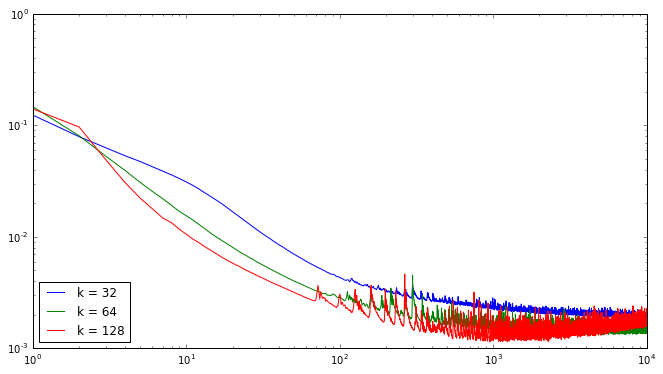

k = 32, PSNR = 27.226901
k = 64, PSNR = 28.643429
k = 128, PSNR = 27.948783


In [31]:
ks = [32, 64, 128]
best_k(ks, sig=25, numit=10000, noise_same=True)

### If we additionally stop early to regularize, then $k=128$ performs best

Noisy observation, PSNR: 20.57
shape:  [1, 16, 16, 32]
optimize with adam 0.01
Final graph size: 1.92 MB
[Iteration 01890] loss=0.01012  true loss=0.00219  true loss orig=0.00219  noise energy=0.00877
Best MSE (wrt noisy) 0.010061163
MSE (wrt true) 0.002138793
shape:  [1, 16, 16, 64]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 01890] loss=0.00905  true loss=0.00163  true loss orig=0.00163  noise energy=0.00877
Best MSE (wrt noisy) 0.008866632
MSE (wrt true) 0.0013756774
shape:  [1, 16, 16, 128]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 01890] loss=0.00830  true loss=0.00125  true loss orig=0.00125  noise energy=0.00877
Best MSE (wrt noisy) 0.008280153
MSE (wrt true) 0.0012258305


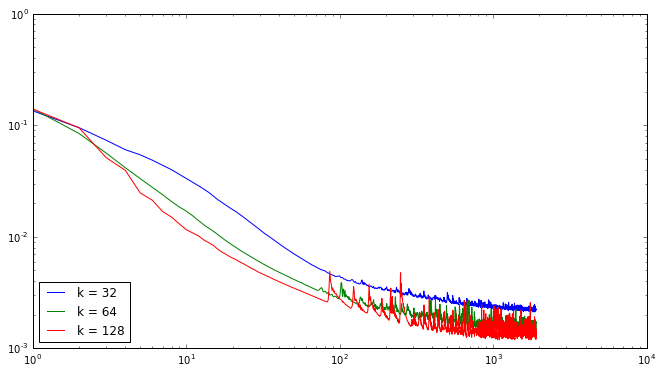

k = 32, PSNR = 26.643901
k = 64, PSNR = 28.310717
k = 128, PSNR = 29.208536


In [29]:
ks = [32, 64, 128]
best_k(ks, sig=25, numit=1900, noise_same=True)

### More noise requires more regularization, either by using a smaller $k$:

Noisy observation, PSNR: 13.69
shape:  [1, 16, 16, 32]
optimize with adam 0.01
Final graph size: 1.92 MB
[Iteration 04990] loss=0.04165  true loss=0.00461  true loss orig=0.00461  noise energy=0.04277
Best MSE (wrt noisy) 0.041615967
MSE (wrt true) 0.00452079
shape:  [1, 16, 16, 64]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 04990] loss=0.03898  true loss=0.00539  true loss orig=0.00539  noise energy=0.04277
Best MSE (wrt noisy) 0.038284533
MSE (wrt true) 0.004998577
shape:  [1, 16, 16, 128]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 04990] loss=0.03582  true loss=0.00770  true loss orig=0.00770  noise energy=0.04277
Best MSE (wrt noisy) 0.03484181
MSE (wrt true) 0.007508739


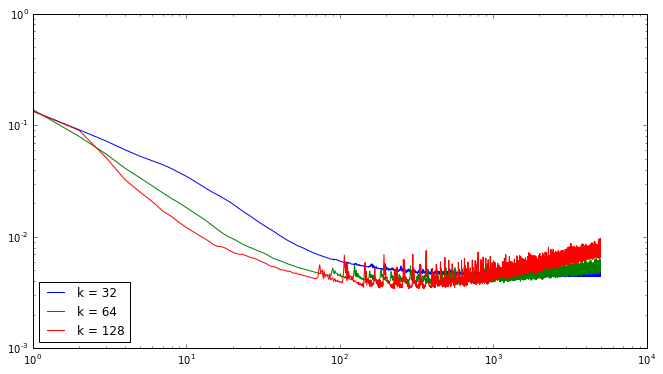

k = 32, PSNR = 23.444748
k = 64, PSNR = 23.112421
k = 128, PSNR = 21.892742


In [30]:
ks = [32, 64, 128]
best_k(ks, sig=60, numit=5000, noise_same=True)

### ... or by stopping even earlier:

Noisy observation, PSNR: 13.71
shape:  [1, 16, 16, 32]
optimize with adam 0.01
Final graph size: 1.92 MB
[Iteration 00790] loss=0.04193  true loss=0.00432  true loss orig=0.00432  noise energy=0.04253
Best MSE (wrt noisy) 0.04198753
MSE (wrt true) 0.004296899
shape:  [1, 16, 16, 64]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 00790] loss=0.04028  true loss=0.00435  true loss orig=0.00435  noise energy=0.04253
Best MSE (wrt noisy) 0.040059343
MSE (wrt true) 0.003945525
shape:  [1, 16, 16, 128]
optimize with adam 0.01
Final graph size: 1.93 MB
[Iteration 00790] loss=0.03960  true loss=0.00397  true loss orig=0.00397  noise energy=0.04253
Best MSE (wrt noisy) 0.039219536
MSE (wrt true) 0.0037477743


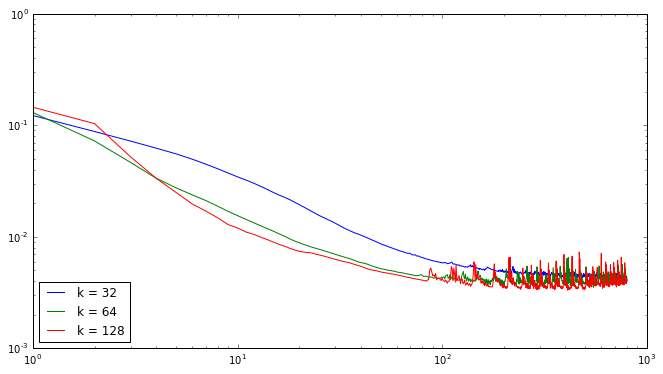

k = 32, PSNR = 23.607799
k = 64, PSNR = 24.001344
k = 128, PSNR = 24.025991


In [28]:
ks = [32, 64, 128]
reload(fit)
best_k(ks, sig=60, numit=800, noise_same=True)